# Final Comparison: EMA vs MACD vs Oversold Reversal vs ATR Filter

In [1]:
import sys
from pathlib import Path

import matplotlib
if not hasattr(matplotlib.rcParams, '_get'):
    matplotlib.rcParams._get = matplotlib.rcParams.get

import matplotlib.pyplot as plt
import pandas as pd

project_root = Path('..').resolve()
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from data_loader import load_ohlcv_csv
from indicators import calculate_ema
from backtest import run_backtest
from qflib_metrics import qflib_metrics_from_returns
from strategy import ema_vs_price_signals
from strategy_macd import macd_signals
from strategy_oversold import oversold_signals
from strategy_atr_filter import atr_filter_signals


In [2]:
df = load_ohlcv_csv('../data/OKX_BTCUSDT, 1D.csv')
df.head()


,open,high,low,close,EMA,Oversold HWO Up,Overbought HWO Down,HWO Up,HWO Down,ATR,MACD,Signal
time,,,,,,,,,,,,
2025-01-17 00:00:00+00:00,99990.9,105847.4,99950.1,104084.4,87477.819959,NaN,NaN,NaN,NaN,3858.413818,806.234733,45.098916
2025-01-18 00:00:00+00:00,104084.5,104984.0,102288.0,104551.6,87780.010756,NaN,NaN,NaN,NaN,3775.384260,1263.568044,288.792741
2025-01-19 00:00:00+00:00,104551.6,106448.6,99639.4,101334.0,88019.904371,NaN,NaN,NaN,NaN,3992.085384,1350.803339,501.194861
2025-01-20 00:00:00+00:00,101334.0,109800.0,99526.4,102264.3,88272.017568,NaN,NaN,NaN,78.924812,4440.765000,1477.968275,696.549544
2025-01-21 00:00:00+00:00,102263.9,107285.8,100111.0,106150.1,88588.443806,NaN,NaN,NaN,NaN,4636.053214,1870.734327,931.386500


In [3]:
results = {}

df['EMA50'] = calculate_ema(df['close'], 50)
pos_ema = ema_vs_price_signals(df, 'EMA50')
bt_ema = run_backtest(df.copy(), pos_ema)
results['EMA_50'] = qflib_metrics_from_returns(bt_ema['strategy_ret'])

pos_macd = macd_signals(df)
bt_macd = run_backtest(df.copy(), pos_macd)
results['MACD'] = qflib_metrics_from_returns(bt_macd['strategy_ret'])

pos_os = oversold_signals(df)
bt_os = run_backtest(df.copy(), pos_os)
results['Oversold'] = qflib_metrics_from_returns(bt_os['strategy_ret'])

pos_atr = atr_filter_signals(df)
bt_atr = run_backtest(df.copy(), pos_atr)
results['ATR_Filter'] = qflib_metrics_from_returns(bt_atr['strategy_ret'])


In [4]:
results_df = pd.DataFrame(results).T
results_df


,total_return,cagr,sharpe_ratio,annualised_vol,max_drawdown,avg_drawdown_duration
EMA_50,0.041440,0.034696,0.271125,0.197657,-0.146291,28.400000
MACD,-0.187579,-0.160122,-0.671701,0.222596,-0.271860,298.000000
Oversold,-0.028873,-0.024310,0.020407,0.243754,-0.223563,91.000000
ATR_Filter,-0.158923,-0.135307,-1.428488,0.098272,-0.173323,91.333333


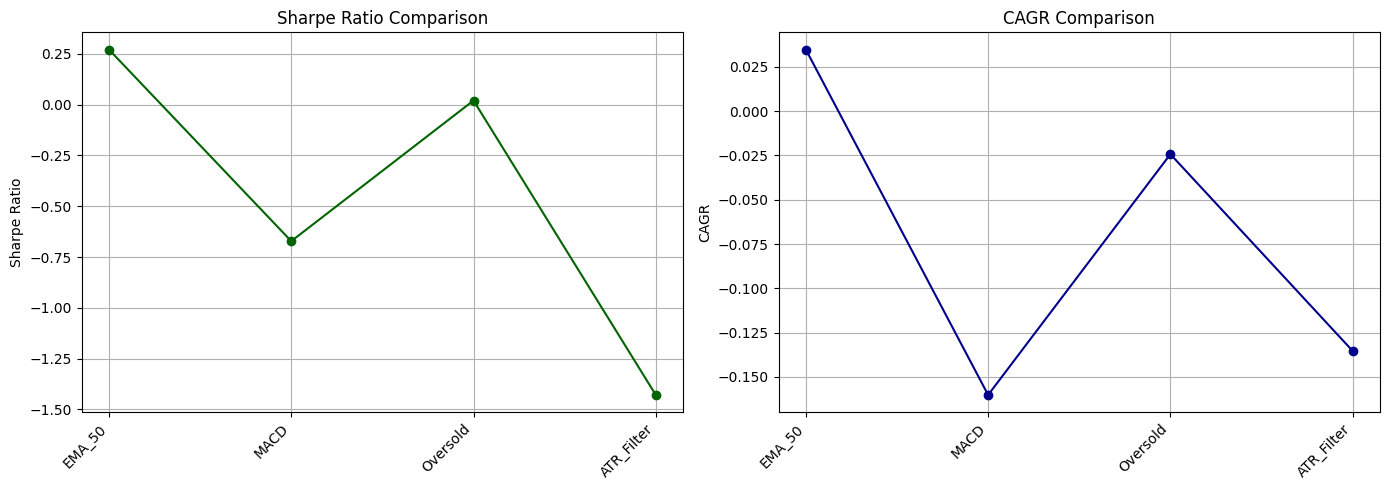

In [5]:
x_positions = range(len(results_df))
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
axes[0].plot(x_positions, results_df['sharpe_ratio'], marker='o', color='darkgreen')
axes[0].set_title('Sharpe Ratio Comparison')
axes[0].set_ylabel('Sharpe Ratio')
axes[0].grid(True)
axes[1].plot(x_positions, results_df['cagr'], marker='o', color='darkblue')
axes[1].set_title('CAGR Comparison')
axes[1].set_ylabel('CAGR')
axes[1].grid(True)
tick_labels = list(results_df.index)
for ax in axes:
    ax.set_xticks(list(x_positions))
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Kesimpulan
- Tabel perbandingan menyoroti performa Sharpe, CAGR, dan risiko utama tiap strategi.
- Visualisasi membantu memilih strategi dengan profil pengembalian vs risiko paling sesuai.
- Eksperimen lanjutan dapat menggabungkan strategi atau melakukan optimasi parameter.
